In [3]:
from __future__ import division, print_function

imgs_dir = '/home/zj1992/windows/work2/datasets/Flukes/CRC_combined constrained/'
annotations_fn = '/home/zj1992/windows/work2/datasets/Flukes/zooniverse-classifications/20150902_zooniverse export_classification data.csv'


In [4]:
import csv
import json

annotations = []
with open(annotations_fn,'r') as annotations_f:
    reader = csv.DictReader(annotations_f)
    for row in reader:
        for k in ['metadata','annotations','subject_data']:
            row[k] = json.loads(row[k])
        annotations.append(row)

In [5]:
import pprint
import random
pp = pprint.PrettyPrinter(indent=2)
sample = list(filter(lambda x: (x['workflow_id'] == '9') and 
                     (x['workflow_version'] == '119.68') or
                     (x['workflow_version'] == '128.68'),annotations))
#print(list(filter(lambda y: len(list(filter(lambda x: x['workflow_version'] == y,sample))) > 2,list(set([x['workflow_version'] for x in sample])))))
pp.pprint(random.choice(sample))

{ 'annotations': [ { u'task': u'T4',
                     u'task_label': u'**Is the end of the whale\'s tail completely visible?** We are really only concerned with the "trailing edge" of the tail -- the part that has the "V." *See the **help** text for examples.*',
                     u'value': u'Yes'},
                   { u'task': u'T5',
                     u'task_label': u'How light or dark is this tail? (see **help** for examples)',
                     u'value': u'Category 5: All dark (0-10% white)'},
                   { u'task': u'T2',
                     u'task_label': u'Select the highest point at each end of each whale tail',
                     u'value': [ { u'details': [],
                                   u'frame': 0,
                                   u'tool': 0,
                                   u'tool_label': u'Tail tip points',
                                   u'x': 927.984375,
                                   u'y': 12.25},
                                 {

_Resized Versions_

- 128.68
- 126.68
- 119.68
- 118.64

_Original Versions_

- 20.7
- 490954.460836
- 23.13
- 35.13
- 48.16
- 55.22
- 65.22
- 460591.460544
- 460837.460836
- 23.13


_Empty Versions_

- 21.9
- 22.13
- 460789.460544
- 78.39 (there are a lot more empties but otherwise it seems to be resized)
- 121.68
- 117.64
- 35.13
- 460546.460544
- 115.64
- 118.68
- 91.51



In [6]:
# there are 3827 subjects annotated
# there are almost twice that many images

from itertools import chain
sbj_retired = {}
retired_conflicts = 0
annotated_fns = set()
for a in annotations:
    sbj = list(a['subject_data'].keys())[0]
    annotated_fns.add(a['subject_data'][sbj]['filename'])
    if sbj not in sbj_retired:
        sbj_retired[sbj] = [a['subject_data'][sbj]['retired']]
    else:
        sbj_retired[sbj].append(a['subject_data'][sbj]['retired'])
#len(list(chain([annotation['subject_data'].keys() for annotation in annotations]))) == len(annotations)

In [7]:
percentage_retired = sum([(len(sbj_retired[sbj]) == 1) for sbj in sbj_retired]) / len(sbj_retired)
print(percentage_retired)

0.126783456746


In [8]:
# just got the identities file from ted
identities_fn = '/home/zj1992/windows/work2/datasets/Flukes/zooniverse-classifications/crc_ids.tsv'
img_id_map = {}
id_img_map = {}
with open(identities_fn,'r') as identities_f:
    reader = csv.DictReader(identities_f, 
                            fieldnames=['wb_context','wb_img_uuid','wb_enc_uuid','crc_id','fn'] ,
                            delimiter='\t')
    for row in reader:
        if row['fn'] not in annotated_fns:
            continue
        if row['fn'] in img_id_map:
            img_id_map[row['fn']].add(row['crc_id'])
        else:
            img_id_map[row['fn']] = set([row['crc_id']])
        if row['crc_id'] in id_img_map:
            id_img_map[row['crc_id']].add(row['fn'])
        else:
            id_img_map[row['crc_id']] = set([row['fn']])


In [9]:
len(img_id_map)

2110

In [10]:
def make_dict_hist(dic):
    hist = {}
    for id_ in dic:
        if len(dic[id_]) in hist:
            hist[len(dic[id_])] += 1
        else:
            hist[len(dic[id_])] = 1
    return hist
            
id_img_hist = make_dict_hist(id_img_map)
print(id_img_hist)

{1: 1207, 2: 201, 3: 56, 4: 33, 5: 13, 6: 7, 7: 4, 8: 2, 9: 3, 10: 1, 13: 1}


In [11]:
from scipy.misc import comb
print("Whales with more than 1 image: %d" % sum([id_img_hist[length] for length in id_img_hist if length > 1]))
print("Number of images usable: %d" % sum([id_img_hist[length]*length for length in id_img_hist if length > 1]))
print("Number of matching pairs: %d" % sum([id_img_hist[length]*comb(length,2) for length in id_img_hist if length > 1]))

Whales with more than 1 image: 321
Number of images usable: 903
Number of matching pairs: 1173


In [12]:
# candidate_annotations is a mapping of image fn to the candidate patches
# we'll also filter out images that are not in the identified set
candidate_annotations = {}
for a in annotations:
    if a['workflow_id'] == '84':
        continue
    if a['workflow_version'] not in map(str,[128.68,126.68,119.68,118.64]):
        continue
    sbj = list(a['subject_data'].keys())[0]
    imgfn = a['subject_data'][sbj]['filename']
    # let's filter out imgfn's that aren't identified or are for a whale with only 1 image associated
    if imgfn not in img_id_map:
        continue
    associated_id = list(img_id_map[imgfn])[0]
    if len(id_img_map[associated_id]) <= 1:
        continue
        
    annot_tasks = {i['task']:i['value'] for i in a['annotations']}
    if ('T3' not in annot_tasks) or ('T2' not in annot_tasks):
        continue
    # if workflow is '9' i.e. on pre-cropped data, we don't have to worry about multiple crops
    # if workflow is '84' we should make sure there's only 1 crop (no way to handle two atm)

    candidate_annotation = {}
    # both workflows should have T2 (tips) and T3 (notch)
    # for T2, if one of the tips is submerged, it should be denoted using tool 1 instead of tool 0
    # we'll still extract it as a patch for now
    # for T3, if the notch is submerged, we should probably skip it. we can tell because the tool should be 1 instead of 0
    if len(annot_tasks['T2']) == 2:
        # assume that image is facing outside of fluke every time
        # so this way, lower x means left
        sorted_tips = sorted(annot_tasks['T2'],key=lambda x: x['x'])
        # annotation coords will be stored as (x,y) tuples
        if sorted_tips[0]['tool'] == 0:    
            candidate_annotation['left'] = (sorted_tips[0]['x'],sorted_tips[0]['y'])
        if sorted_tips[1]['tool'] == 0:
            candidate_annotation['right'] = (sorted_tips[1]['x'],sorted_tips[0]['y'])
        
    if (len(annot_tasks['T3']) == 1) and (annot_tasks['T3'][0]['tool'] == 0):
        candidate_annotation['notch'] = (annot_tasks['T3'][0]['x'],annot_tasks['T3'][0]['y'])
        
    if imgfn in candidate_annotations:
        candidate_annotations[imgfn]['patch_cands'].append(candidate_annotation)
    else:
        candidate_annotations[imgfn] = {'patch_cands':[candidate_annotation],'id':associated_id}
        
        

In [13]:
len(candidate_annotations)

880

In [14]:
# let's see how many of the candidate annotations have all three patches
missing = {'left':[],'right':[],'notch':[]}
avg_n_annotations = 0
for imgfn in candidate_annotations:
    avg_n_annotations += len(candidate_annotations[imgfn])
    for patch in missing:
        if all([patch not in i for i in candidate_annotations[imgfn]['patch_cands']]):
            missing[patch].append(imgfn)
print('\n'.join(["%s: %d e.g. %s" % (patch, len(missing[patch]), random.choice(missing[patch])) for patch in missing]))
print(avg_n_annotations / len(candidate_annotations))

notch: 20 e.g. 20100816-Kanes-05591.jpg
right: 17 e.g. CINMS_20120712_A7406.jpg
left: 14 e.g. CINMS-20090327-A0915.jpg
2.0


In [15]:
# it seems like not a lot, so let's say that if any patch is missing we'll take the image out
any_missing = set(list(chain(*missing.values())))
filtered_id_img_map = {}
for crcid in id_img_map:
    filtered_id_img_map[crcid] = list(filter(lambda x: x not in any_missing, id_img_map[crcid]))
candidate_annotations = {imgfn:candidate_annotations[imgfn] for imgfn in candidate_annotations if 
                         (len(filtered_id_img_map[candidate_annotations[imgfn]['id']]) > 1) 
                         and (imgfn not in any_missing)}
print(len(candidate_annotations))

816


In [16]:
filtered_id_img_hist = make_dict_hist(filtered_id_img_map)
print("Whales with more than 1 image: %d" % sum([filtered_id_img_hist[length] for length in filtered_id_img_hist if length > 1]))
print("Number of images usable: %d" % sum([filtered_id_img_hist[length]*length for length in filtered_id_img_hist if length > 1]))
print("Number of matching pairs: %d" % sum([filtered_id_img_hist[length]*comb(length,2) for length in filtered_id_img_hist if length > 1]))

Whales with more than 1 image: 300
Number of images usable: 839
Number of matching pairs: 1043


In [17]:
print(filtered_id_img_hist)

{0: 1, 1: 1227, 2: 184, 3: 56, 4: 32, 5: 14, 6: 6, 7: 1, 8: 4, 9: 1, 10: 1, 11: 1}


In [18]:
import numpy as np
from scipy.spatial.distance import euclidean
import copy
import time
bad_annot_counter = 0

def remove_outlier(cand_annots, avgs, patches, std_thresh=50):
    cand_annots_copy = copy.deepcopy(cand_annots)
    patch_reduc_too_much = False
    for patch in patches:
        orig_patches = [i[patch] for i in cand_annots_copy if patch in i]
        print("Average for patch %s: %s" % (patch, np.average(orig_patches,axis=0)))
        orig_patches_len = len(orig_patches)
        while (any(np.std(orig_patches,axis=0) > std_thresh)
              and len(orig_patches) > 2):
            distances = [euclidean(avgs[patch],i) for i in orig_patches]
            to_remove = np.argmax(distances)
            #print(cand_annots_copy[to_remove])
            #print(len([i[patch] for i in cand_annots_copy if patch in i]))
            print("Removing from patch collection %s: %s" % (patch, orig_patches.pop(to_remove)))
            #cand_annots_copy[to_remove].pop(patch, None)
            #print(cand_annots_copy[to_remove])
            #print(len([i[patch] for i in cand_annots_copy if patch in i]))
        if len(orig_patches) == 2:
            print("Warning: Removing outliers brought number of patches down to 2")
            patch_reduc_too_much = True
        avgs[patch] = np.average(orig_patches,axis=0)
        print("New Average for patch %s: %s, %0.2f%% of annotations removed" % (patch, avgs[patch], 
                                                                100*(orig_patches_len - len(orig_patches))/orig_patches_len))
    return avgs, patch_reduc_too_much

In [19]:

def get_avg_annotation(cand_annots, imgname, std_thresh=50):
    # for every annotation, we could easily just trust the data and take the average
    # however we'll also check the standard deviation, and if it's really high then 
    # there might be an outlier
    patches = ['left','notch','right']
    avgs = {patch:np.average([i[patch] for i in cand_annots if patch in i],axis=0) for patch in patches}
    stds = {patch:np.std([i[patch] for i in cand_annots if patch in i],axis=0) for patch in patches}
    
    bad_annot = False
    bad_patches = []
    for patch in avgs:
        for dimension in range(avgs[patch].shape[0]):
            if stds[patch][dimension] > std_thresh:
                bad_annot = True
                bad_patches.append(patch)
                print("Warning on Image %s: %s has std %0.2f on dimension %d" % (imgname, patch,stds[patch][dimension],dimension))
    patch_reduc = False
    if len(cand_annots) > 3 and bad_annot:
        avgs, patch_reduc = remove_outlier(cand_annots, avgs, bad_patches, std_thresh=std_thresh)
    return avgs, stds, patch_reduc

avg_annots = {}
for imgfn in candidate_annotations:
    avg, std, bad = get_avg_annotation(candidate_annotations[imgfn]['patch_cands'], imgfn, std_thresh=50)
    for patch in ['left','notch','right']:
        avg[patch] = map(lambda x: int(x+0.5),avg[patch])
    avg_annots[imgfn] = avg
    if bad:
        bad_annot_counter += 1
print(bad_annot_counter)

Warning on Image 20120528-DB-4250.jpg: right has std 71.47 on dimension 0
Warning on Image 20120528-DB-4250.jpg: left has std 65.10 on dimension 0
Average for patch right: [ 871.086795     19.19973648]
Removing from patch collection right: (753.03125, 17.25)
Removing from patch collection right: (763.5901064806438, 22.250975630907988)
New Average for patch right: [ 916.1972417    18.97943595], 28.57% of annotations removed
Average for patch left: [ 84.38833036  19.19973648]
Removing from patch collection left: (243.61996662847034, 22.250975630907988)
New Average for patch left: [ 57.84972432  18.69119662], 14.29% of annotations removed
Warning on Image CINMS_20100408_A1436.jpg: left has std 56.19 on dimension 0
Average for patch left: [ 52.03625593  35.52543762]
Removing from patch collection left: (171.55375681858175, 21.622382544430756)
New Average for patch left: [ 37.09656832  37.2633195 ], 11.11% of annotations removed
Warning on Image 12541-20080916-EAF-0122EDIT.jpg: right has st

12160-CINMS-20081115-A3209edit.jpg
{'notch': (128, 128, 3), 'right': (128, 128, 3), 'left': (128, 128, 3)}
{'notch': [(415, 96), (543, 224)], 'right': [(832, 23), (960, 151)], 'left': [(0, 23), (128, 151)]}


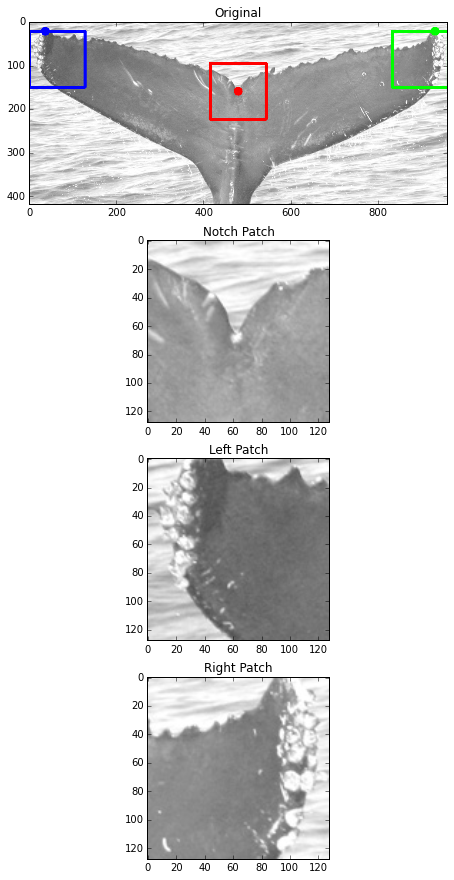

In [20]:
# now we have decent averages, so let's sample the patches from the images
from os.path import join
import cv2
def collect_patches(img_dir, imgfn, patch_locs, patch_size):
    img = cv2.imread(join(img_dir, imgfn))
    patch_coords = {} # pretty much just for plotting
    notch_loc = patch_locs['notch']#map(lambda x: int(x+0.5),patch_locs['notch'])
    left_loc = patch_locs['left']#map(lambda x: int(x+0.5),patch_locs['left'])
    right_loc = patch_locs['right']#map(lambda x: int(x+0.5),patch_locs['right'])
    #print(notch_loc)
    #print(left_loc)
    #print(right_loc)
    #print(img.shape)
    # x is axis 1, y is axis 0
    # sample notch as center on x and y
    # edge case to handle here, but it does come up if the image has a low enough height
    lower_notch_border = notch_loc[1] + patch_size//2
    upper_notch_border = notch_loc[1] - patch_size//2
    if img.shape[0] < patch_size:
        print("Warning: Image %s is too small for patch size %d" % (imgfn, patch_size))
    if lower_notch_border > img.shape[0]:
        lower_notch_border = img.shape[0]
        upper_notch_border = img.shape[0] - patch_size
    if upper_notch_border < 0:
        upper_notch_border = 0
        lower_notch_border = patch_size
    
    notch_patch = img[upper_notch_border:lower_notch_border,
                      notch_loc[0]-patch_size//2:notch_loc[0]+patch_size//2,:]
    
    patch_coords['notch'] = [(notch_loc[0]-patch_size//2,upper_notch_border),
                             (notch_loc[0]+patch_size//2,lower_notch_border)]
    # we have to take care with the x-values here
    # essentially if loc[1] - patch_size / 2 < 0, we'll add abs(loc[1] - patch_size / 2)
    left_left_border = left_loc[0] - patch_size//2
    right_left_border = left_loc[0] + patch_size//2
    

    if left_left_border < 0:
        right_left_border = patch_size
        left_left_border = 0
        
    upper_left_border = left_loc[1]
    lower_left_border = left_loc[1] + patch_size
    if lower_left_border > img.shape[0]:
        upper_left_border = img.shape[0] - patch_size
        lower_left_border = img.shape[0]
    # sample left as topmost point on y, and center point on x, though maybe we want do something more intelligent here?
    left_patch = img[upper_left_border:lower_left_border, # numpy is backwards somewhat on the y-axis
                     left_left_border:right_left_border,:]
    patch_coords['left'] = [(left_left_border,upper_left_border),
                            (right_left_border,lower_left_border)]
    
    left_right_border = right_loc[0] - patch_size//2
    right_right_border = right_loc[0] + patch_size//2
    if right_right_border > img.shape[1]:
        left_right_border = img.shape[1] - patch_size
        right_right_border = img.shape[1]
        
    upper_right_border = right_loc[1]
    lower_right_border = right_loc[1] + patch_size
    if lower_right_border > img.shape[0]:
        upper_right_border = img.shape[0] - patch_size
        lower_right_border = img.shape[0]
    
    # similar for right
    right_patch = img[upper_right_border:lower_right_border,
                      left_right_border:right_right_border,:]
    patch_coords['right'] = [(left_right_border,upper_right_border),
                             (right_right_border,lower_right_border)]
    
    return {'notch':notch_patch,
            'left':left_patch,
            'right':right_patch}, patch_coords

import matplotlib.pyplot as plt
%matplotlib inline
def view_img_patches(img_dir, imgfn, patches, centers, patch_coords, patch_size):
    original_img = cv2.imread(join(img_dir, imgfn))
    cv2.circle(original_img, tuple(centers['notch']), 10, (255,0,0),-1)
    cv2.circle(original_img, tuple(centers['left']), 10, (0,0,255),-1)
    cv2.circle(original_img, tuple(centers['right']), 10, (0,255,0),-1)

    cv2.rectangle(original_img,patch_coords['notch'][0],patch_coords['notch'][1],(255,0,0),5)
    cv2.rectangle(original_img,patch_coords['left'][0],patch_coords['left'][1],(0,0,255),5)
    cv2.rectangle(original_img,patch_coords['right'][0],patch_coords['right'][1],(0,255,0),5)

    fig = plt.figure(figsize=(15,15))
    orig_ax = fig.add_subplot(411)
    orig_ax.set_title("Original")
    orig_ax.imshow(original_img)
    
    notch_ax = fig.add_subplot(412)
    notch_ax.set_title("Notch Patch")
    notch_ax.imshow(patches['notch'])
    
    left_ax = fig.add_subplot(413)
    left_ax.set_title("Left Patch")
    left_ax.imshow(patches['left'])
    
    right_ax = fig.add_subplot(414)
    right_ax.set_title("Right Patch")
    right_ax.imshow(patches['right'])
    

img_dir = '/home/zj1992/windows/work2/datasets/Flukes/CRC_combined constrained'
random_imgfn = random.choice(avg_annots.keys())
print(random_imgfn)
patches, patch_coords = collect_patches(img_dir, random_imgfn, avg_annots[random_imgfn], 128)
print({k:patches[k].shape for k in patches})
print(patch_coords)
view_img_patches(img_dir, random_imgfn, patches, avg_annots[random_imgfn], patch_coords, 128)

In [21]:
# now we need to make pairs for each image
# make a new id -> img map to handle any filtering that happened
patch_id_img_map = {}
for imgfn in avg_annots:
    crcid = list(img_id_map[imgfn])[0]
    patches, _ = collect_patches(img_dir, imgfn, avg_annots[imgfn], 128)
    if crcid not in patch_id_img_map:
        patch_id_img_map[crcid] = [patches]
    else:
        patch_id_img_map[crcid].append(patches)
patch_id_img_hist = make_dict_hist(patch_id_img_map)

In [22]:
print("Whales with more than 1 image: %d" % sum([patch_id_img_hist[length] for length in patch_id_img_hist if length > 1]))
print("Number of images usable: %d" % sum([patch_id_img_hist[length]*length for length in patch_id_img_hist if length > 1]))
print("Number of matching pairs: %d" % sum([patch_id_img_hist[length]*comb(length,2) for length in patch_id_img_hist if length > 1]))

Whales with more than 1 image: 293
Number of images usable: 812
Number of matching pairs: 999


In [23]:
# now we want a dataset of ~50% matching patches (which will unfortunately be all of them)
# and 50% non-matching patches
# TODO (maybe) create dataset entirely of non-matching pairs from whales not in this dataset for testing
from itertools import combinations
matching_combinations = []
for crcid in patch_id_img_map:
    for combo in combinations(patch_id_img_map[crcid],2):
        matching_combinations.append(combo)

non_matching_combinations = []
max_amount = max(patch_id_img_hist.keys())
for i in range(max_amount):
    indv_patches = [patch_id_img_map[crcid][i] for crcid in patch_id_img_map if (
        len(patch_id_img_map[crcid]) > 1 and #awkward but we don't want to skip i = 0
        len(patch_id_img_map[crcid]) > i)]
    for combo in combinations(indv_patches,2):
        non_matching_combinations.append(combo)


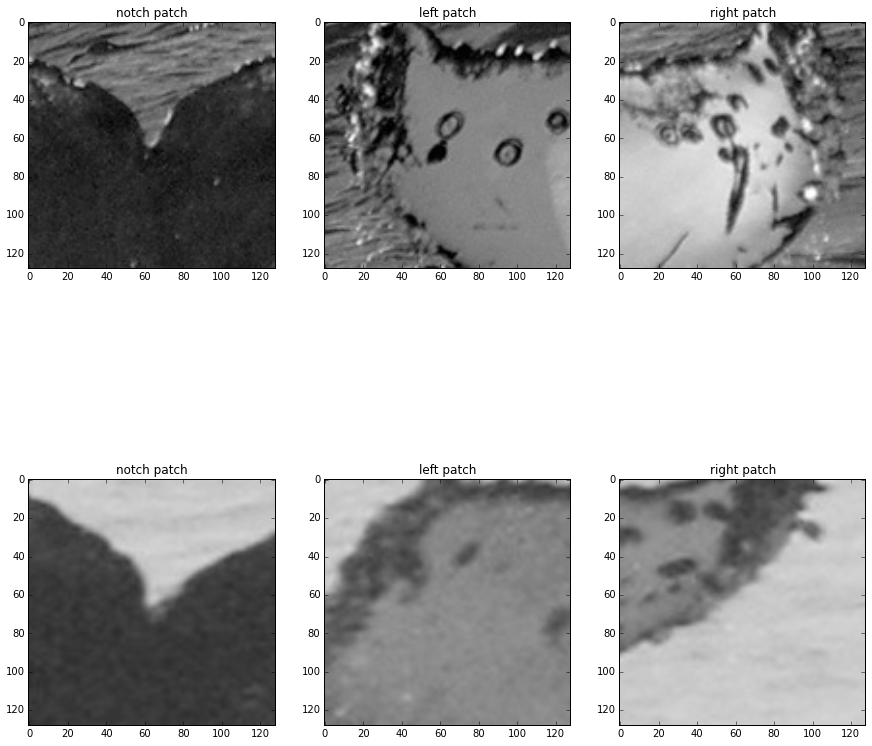

In [24]:
def view_combination(combo):
    f, axarr = plt.subplots(2,3,figsize=(15,15))
    for i in range(2):
        for label_ind, label in enumerate(['notch','left','right']):
            axarr[i][label_ind].set_title("%s patch" % label)
            axarr[i][label_ind].imshow(combo[i][label])
view_combination(random.choice(matching_combinations))

In [25]:
# resample negative class size to match positive class size
from sklearn.utils import resample
neg_examples = resample(non_matching_combinations, replace=False, n_samples=len(matching_combinations))


In [26]:
print(len(neg_examples))
print(len(matching_combinations))

999
999


In [32]:
matching_combinations[0][0]['left']

array([[[186, 186, 186],
        [182, 182, 182],
        [181, 181, 181],
        ..., 
        [186, 186, 186],
        [187, 187, 187],
        [186, 186, 186]],

       [[181, 181, 181],
        [183, 183, 183],
        [180, 180, 180],
        ..., 
        [184, 184, 184],
        [182, 182, 182],
        [181, 181, 181]],

       [[180, 180, 180],
        [178, 178, 178],
        [175, 175, 175],
        ..., 
        [182, 182, 182],
        [180, 180, 180],
        [178, 178, 178]],

       ..., 
       [[174, 174, 174],
        [171, 171, 171],
        [165, 165, 165],
        ..., 
        [225, 225, 225],
        [217, 217, 217],
        [210, 210, 210]],

       [[178, 178, 178],
        [178, 178, 178],
        [176, 176, 176],
        ..., 
        [217, 217, 217],
        [204, 204, 204],
        [191, 191, 191]],

       [[184, 184, 184],
        [188, 188, 188],
        [188, 188, 188],
        ..., 
        [202, 202, 202],
        [185, 185, 185],
        [169, 169,

In [28]:
import cPickle as pickle
all_images = list(chain(matching_combinations, neg_examples))
all_labels = [1]*len(matching_combinations) + [0]*len(neg_examples)
shuffled_images, shuffled_labels = resample(all_images, all_labels, replace=False)

from sklearn.cross_validation import train_test_split
train_images, test_images, train_labels, test_labels = train_test_split(shuffled_images, shuffled_labels, test_size=0.25)
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2)

from os.path import exists
from os import mkdir
def save_dataset(dataset_name, train, val, test):
    working_dir = join("/home/zj1992/windows/work2/datasets/Flukes/patches",dataset_name)
    if not exists(working_dir):
        mkdir(working_dir)
    else:
        print("Warning: Overwriting %s y/n" % dataset_name)
        confirm = raw_input()
        if confirm != 'y':
            return
    with open(join(working_dir,'train.pkl'),'wb') as f:
        pickle.dump(train,f)
    with open(join(working_dir,'val.pkl'),'wb') as f:
        pickle.dump(val,f)
    with open(join(working_dir,'test.pkl'),'wb') as f:
        pickle.dump(test,f)
        
save_dataset("20150902_annot_nomissing",(train_images, train_labels),
                                        (val_images, val_labels),
                                        (test_images, test_labels))
